In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
cst = pd.read_csv("./data/customers.csv", parse_dates=["signup_date"])
orders = pd.read_csv("./data/orders.csv", parse_dates=["order_date"])

In [4]:
cst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  1000 non-null   object        
 1   gender       1000 non-null   object        
 2   birth_year   1000 non-null   int64         
 3   city         1000 non-null   object        
 4   signup_date  1000 non-null   datetime64[ns]
 5   source       1000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 47.0+ KB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4271 entries, 0 to 4270
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   order_id     4271 non-null   object        
 1   customer_id  4271 non-null   object        
 2   order_date   4271 non-null   datetime64[ns]
 3   revenue      4265 non-null   float64       
 4   items_count  4271 non-null   int64         
 5   used_coupon  4271 non-null   int64         
 6   returned     4271 non-null   int64         
 7   channel      4265 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 267.1+ KB


In [6]:
orders.isna().sum()

order_id       0
customer_id    0
order_date     0
revenue        6
items_count    0
used_coupon    0
returned       0
channel        6
dtype: int64

In [7]:
orders = orders.drop_duplicates()

In [8]:
if orders["revenue"].isna().any():
    orders["revenue"] = orders.groupby("channel")["revenue"].transform(
        lambda s: s.fillna(s.median())
    ).fillna(orders["revenue"].median())

In [9]:
orders.head()

,order_id,customer_id,order_date,revenue,items_count,used_coupon,returned,channel
0,O0000001,C000001,2023-08-30,24.50,3,0,0,web
1,O0000002,C000001,2023-09-01,46.28,1,0,0,app
2,O0000003,C000001,2024-04-14,40.32,1,0,0,web
3,O0000004,C000002,2023-02-15,23.47,1,0,0,store
4,O0000005,C000002,2024-02-01,18.37,6,0,0,app


In [10]:
orders['order_date'] = pd.to_datetime(orders['order_date'], format='%Y-%m-%d')
orders['revenue'] = pd.to_numeric(orders['revenue'], errors='coerce')
orders['customer_id'] = orders['order_id'].astype(str)
cst['customer_id'] = cst['customer_id'].astype(str)

In [11]:
low, high = orders['revenue'].quantile([0.01, 0.99])
orders['revenue'] = orders['revenue'].clip(lower=low, upper=high)

In [12]:
cutoff_date = orders['order_date'].max() + pd.Timedelta(days=1)
rfm = orders.groupby('customer_id').agg({
    'order_date' : lambda x: (cutoff_date - x.max()).days,
    'order_id' : 'count',
    'revenue' : 'sum'
}).rename(columns={
    'order_date' : 'Recency',
    'order_id' : 'Frequency',
    'revenue' : 'Monetary'
})

In [13]:
rfm.head()

,Recency,Frequency,Monetary
customer_id,,,
O0000001,732,1,24.50
O0000002,730,1,46.28
O0000003,504,1,40.32
O0000004,928,1,23.47
O0000005,577,1,18.37


In [14]:
rfm['Recency_Score'] = pd.qcut(rfm['Recency'], 5, labels = [ 5, 4, 3, 2, 1 ])
rfm['Frequency_Score'] = pd.cut(rfm['Frequency'].rank(method='first'), 5, labels = [1, 2, 3, 4, 5])
rfm['Monetary_Score'] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])
rfm['RFM_Score'] = (rfm['Recency_Score'].astype(str) +
                    rfm['Frequency_Score'].astype(str) +
                    rfm['Monetary_Score'].astype(str))

rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
customer_id,,,,,,,
O0000001,732,1,24.50,2,1,3,213
O0000002,730,1,46.28,2,1,5,215
O0000003,504,1,40.32,3,1,5,315
O0000004,928,1,23.47,1,1,3,113
O0000005,577,1,18.37,2,1,2,212


In [ ]:
seg_map = {}

for r in range(1, 6):               # Recency
    for f in range(1, 6):           # Frequency
        for m in range(1, 6):       # Monetary
            code = f"{r}{f}{m}"

            if (r == 5 and f == 5 and m == 5):
                seg_map[code] = "VIP"
            elif (r >= 4 and f >= 4 and m >= 4):
                seg_map[code] = "Champions"
            elif (r in [3,4] and f >= 4 and m >= 3):
                seg_map[code] = "Loyal_Customers"
            elif (r >= 4 and f in [2,3] and m >= 3):
                seg_map[code] = "Potential_Loyalists"
            elif (r >= 4 and f in [1,2] and m in [2,3,4]):
                seg_map[code] = "Promising"
            elif (r >= 3 and f == 1 and m <= 2):
                seg_map[code] = "New_Customers"
            elif (r in [3,4,5] and f in [1,2] and m in [3,4,5]):
                seg_map[code] = "New_HighValue"
            elif (r in [2,3] and f in [2,3] and m in [2,3]):
                seg_map[code] = "Need_Attention"
            elif (r in [1,2] and f in [2,3,4] and m >= 2):
                seg_map[code] = "At_Risk"
            elif (r in [1,2] and f == 5 and m in [3,4,5]):
                seg_map[code] = "Cant_Loose"
            elif (r in [1,2] and f <= 3 and m <= 3):
                seg_map[code] = "Hibernating"
            elif (r in [2,3] and f <= 3 and m in [1,2,3]):
                seg_map[code] = "About_to_Sleep"
            else:
                seg_map[code] = "General_Customers"

In [16]:
rfm['Segment'] = rfm['RFM_Score'].astype(str).replace(seg_map, regex=True)
rfm.head(50)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment
customer_id,,,,,,,,
O0000001,732,1,24.50,2,1,3,213,Hibernating
O0000002,730,1,46.28,2,1,5,215,General_Customers
O0000003,504,1,40.32,3,1,5,315,New_HighValue
O0000004,928,1,23.47,1,1,3,113,Hibernating
O0000005,577,1,18.37,2,1,2,212,Hibernating
O0000006,236,1,27.60,4,1,4,414,Promising
O0000007,74,1,11.00,5,1,1,511,New_Customers
O0000008,927,1,14.52,1,1,1,111,Hibernating
O0000009,594,1,74.84,2,1,5,215,General_Customers


In [17]:
rfm['Segment'].unique()

array(['Hibernating', 'General_Customers', 'New_HighValue', 'Promising',
       'New_Customers', 'Potential_Loyalists', 'At_Risk',
       'Need_Attention', 'About_to_Sleep', 'Champions', 'Loyal_Customers',
       'Cant_Loose', 'VIP'], dtype=object)

In [18]:
rfm['Segment'].value_counts()

Segment
General_Customers      1136
At_Risk                 658
Potential_Loyalists     388
Hibernating             339
New_HighValue           304
Promising               260
Loyal_Customers         251
Need_Attention          249
Champions               246
Cant_Loose              204
New_Customers           134
About_to_Sleep           61
VIP                      36
Name: count, dtype: int64

In [19]:
segment_profile = rfm.groupby('Segment').agg(
    Count_customers=('Recency', 'count'),
    Median_Recency=('Recency', 'median'),
    Median_Frequency=('Frequency', 'median'),
    Median_Monetary=('Monetary', 'median')
)

segment_profile.head()

,Count_customers,Median_Recency,Median_Frequency,Median_Monetary
Segment,,,,
About_to_Sleep,61,487.0,1.0,11.350
At_Risk,658,785.5,1.0,29.120
Cant_Loose,204,755.0,1.0,31.395
Champions,246,199.0,1.0,34.905
General_Customers,1136,372.0,1.0,15.605


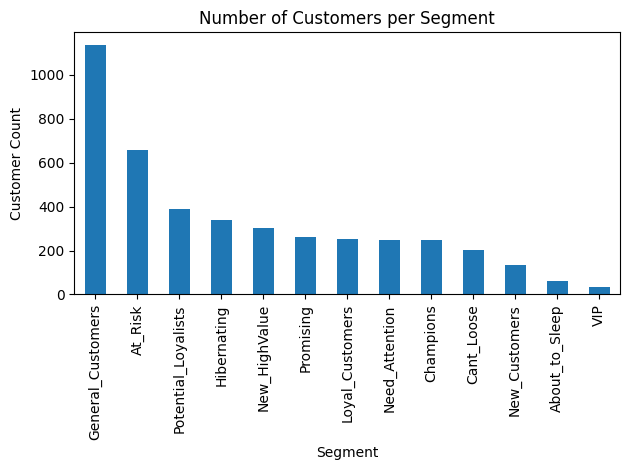

In [20]:
counts = rfm["Segment"].value_counts().sort_values(ascending=False)

plt.figure()
counts.plot(kind="bar")
plt.title("Number of Customers per Segment")
plt.xlabel("Segment")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()


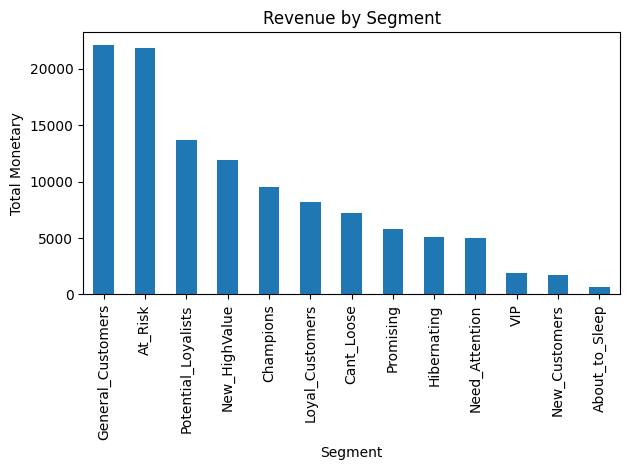

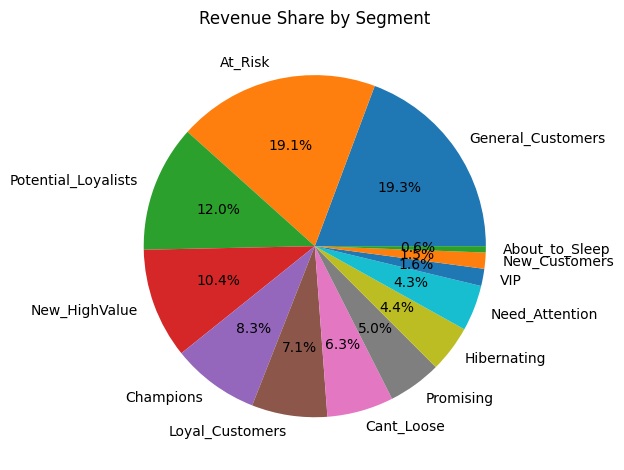

In [21]:
rev_by_seg = rfm.groupby("Segment")["Monetary"].sum().sort_values(ascending=False)

# Bar chart
plt.figure()
rev_by_seg.plot(kind="bar")
plt.title("Revenue by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Monetary")
plt.tight_layout()
plt.show()

# Pie chart
plt.figure()
rev_by_seg.plot(kind="pie", autopct="%1.1f%%")
plt.ylabel("")
plt.title("Revenue Share by Segment")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

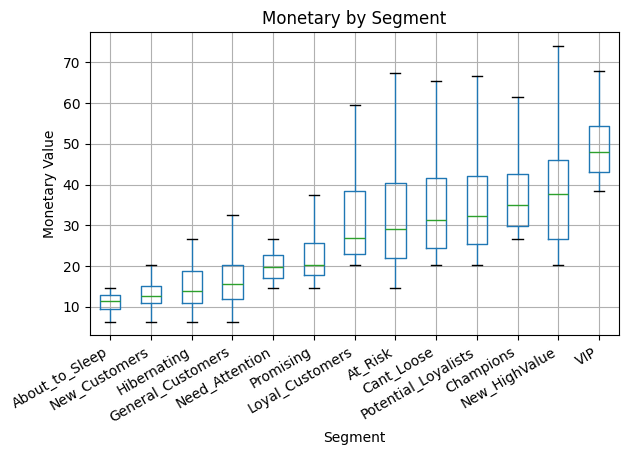

In [22]:
order = (rfm.groupby("Segment")["Monetary"]
           .median()
           .sort_values()
           .index)
rfm["Segment"] = pd.Categorical(rfm["Segment"], categories=order, ordered=True)

plt.figure(figsize=(12,6))
rfm.boxplot(column="Monetary", by="Segment", showfliers=False)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Monetary Value")
plt.title("Monetary by Segment"); plt.suptitle("")
plt.tight_layout(); plt.show()


In [23]:
rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment
customer_id,,,,,,,,
O0000001,732,1,24.50,2,1,3,213,Hibernating
O0000002,730,1,46.28,2,1,5,215,General_Customers
O0000003,504,1,40.32,3,1,5,315,New_HighValue
O0000004,928,1,23.47,1,1,3,113,Hibernating
O0000005,577,1,18.37,2,1,2,212,Hibernating
